## Download logs

In [1]:
# TODO

## Parse data to pandas

In [6]:
%matplotlib inline

In [103]:
from io import StringIO
from matplotlib import pyplot as plt
import csv
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [91]:
def create_dataframe(csv_string, col_names, quotechar='"'):
    return pd.read_csv(StringIO(csv_string), sep=",(?![^{]*\})",
                       quoting=csv.QUOTE_ALL, quotechar=quotechar,
                       names=col_names, header=None)


def filter_logs(csv_file, keyword):
    with open(csv_file) as f:
        return ''.join([line for line in f if keyword in line]).strip()


def get_new_tree_info(log_file):
    logs = filter_logs(log_file, "new-tree-info")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "num-scanned", "gamma", "tree"]
    return create_dataframe(logs, cols)


def get_performance(log_file):
    logs = filter_logs(log_file, "boosting_speed")

    cols = ["level", "time", "module", "log-type",
            "overall-duration", "overall-count", "overall-speed",
            "learner-duration", "learner-count", "learner-speed"]
    return create_dataframe(logs, cols)


def get_true_z(log_file):
    logs = filter_logs(log_file, "validate-only")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "true-z", "auprc"]
    return create_dataframe(logs, cols)

def get_network_out(log_file):
    logs = filter_logs(log_file, "network-sent-out")

    cols = ["level", "time", "module", "log-type",
            "index", "score", "num-neighbors"]
    return create_dataframe(logs, cols)

def get_network_in(log_file):
    logs = filter_logs(log_file, "message-received")

    # Removed json message for now
    parsed = []
    for line in logs.split('\n'):
        line = line.strip()
        idx = line.find(', [')
        line = line[:idx]  # + ", '{}'".format(line[idx+2:])
        parsed.append(line)
    logs = '\n'.join(parsed)

    cols = ["level", "time", "module", "log-type",
            "idx", "remote_ip", "score", "json_len"]  # , "json"]
    # cols = ["level", "time", "module", "log-type",
    #         "index", "remote_ip", "remote-index", "score", "json_len"]  #, "json"]
    return create_dataframe(logs, cols, quotechar="'")

def get_model_replace(log_file):
    logs = filter_logs(log_file, "model-replaced")

    cols = ["level", "time", "module", "log-type",
            "remote-score", "local-score", "remote-model-len", "local-model-len"]
    return create_dataframe(logs, cols)

In [92]:
trees = []
speed = []
true_z = []

network_in = []
network_out = []
model_replace = []

for i in range(5):
    log_path = "../logs-analysis/network/node-%d/run-network.log" % i
    validate_path = "../logs-analysis/network/node-%d/validate.log" % i

    _trees = get_new_tree_info(log_path)
    # _trees["estimated-z"] = np.exp(-(_trees["gamma"]**2).cumsum())
    _trees["node"] = i
    trees.append(_trees)

    _speed = get_performance(log_path)
    _speed["node"] = i
    speed.append(_speed)

    _true_z = get_true_z(validate_path)
    _true_z["node"] = i
    true_z.append(_true_z)

    _network_in = get_network_in(log_path)
    _network_in["node"] = i
    network_in.append(_network_in)

    _network_out = get_network_out(log_path)
    _network_out["node"] = i
    network_out.append(_network_out)

    _model_replace = get_model_replace(log_path)
    _model_replace["node"] = i
    model_replace.append(_model_replace)

trees = pd.concat(trees)
speed = pd.concat(speed)
true_z = pd.concat(true_z)

network_in = pd.concat(network_in)
network_out = pd.concat(network_out)
model_replace = pd.concat(model_replace)

trees = trees.drop(columns=["level", "module", "log-type", "tree"])
true_z = true_z.drop(columns=["level", "module", "log-type", "time"])
speed = speed.drop(columns=["level", "module", "log-type"])

network_in = network_in.drop(columns=["level", "module", "log-type"])
network_out = network_out.drop(columns=["level", "module", "log-type"])
model_replace = model_replace.drop(columns=["level", "module", "log-type"])

In [158]:
import pickle


with open("tree_info_local.pkl", 'rb') as f:
    tree_info_local = pickle.load(f)
tree_info_local["time"] -= tree_info_local["time"][0]
max_range = tree_info_local["range"].max()
tree_info_local = tree_info_local[tree_info_local["range"] == max_range]

In [172]:
tree_info = trees.merge(true_z, on=["tree-id", "node"], how="outer") \
                 .sort_values(by=['node', 'tree-id']) \
                 .fillna(method="pad")
tree_info["time"] -= tree_info["time"].iloc[0]
tree_info.head()

,time,tree-id,num-scanned,gamma,node,true-z,auprc
0,0.000000,1,10000.0,0.496800,0,0.111951,0.006288
1942,0.000000,10,10000.0,0.496800,0,0.085971,0.032657
1,158.402937,11,646000.0,0.041522,0,0.085971,0.032657
2,159.367541,13,320000.0,0.041522,0,0.085971,0.032657
3,166.158813,20,143000.0,0.033633,0,0.077399,0.053229


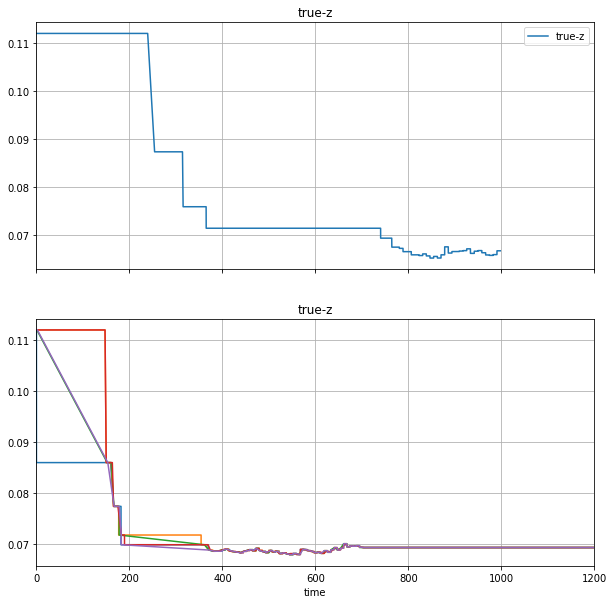

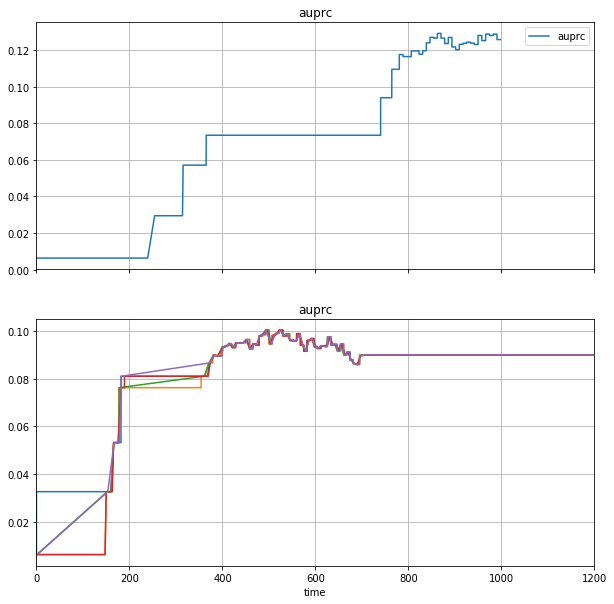

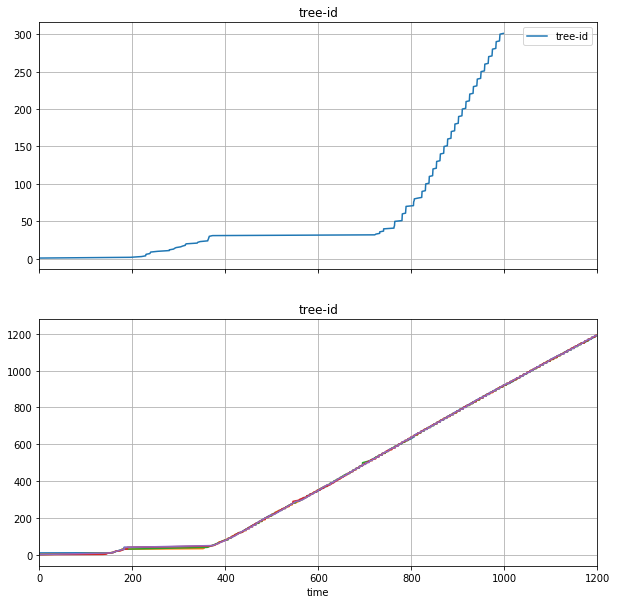

In [179]:
for field in ["true-z", "auprc", "tree-id"]:
    plt.figure(figsize=(10, 10))
    ax1=plt.subplot(211)
    tree_info_local.plot(
        x="time", y=field,
        grid=True,
        ax=ax1, title=field
    );
    ax1.set_xlim(0, 1200)
    ax2=plt.subplot(212)
    for i in range(6):
        # ax = plt.subplot(3, 2, i + 1)
        df = tree_info[tree_info["node"] == i]
        if df.shape[0]:
            df.plot(
                x="time", y=field,
                grid=True,
                ax=ax2, title=field,
                legend=None,
                sharex=ax1
            );
    ax2.set_xlim(0, 1200)

In [163]:
network_in.head()

,time,idx,remote_ip,score,json_len,node
0,851276.411214,0,34.235.135.227:8888,0.273714,404,0
1,851282.908085,1,34.235.135.227:8888,0.288012,600,0
2,851285.339045,2,34.235.135.227:8888,0.299594,795,0
3,851285.373887,3,34.235.135.227:8888,0.311175,990,0
4,851285.487986,4,34.235.135.227:8888,0.322757,1184,0


In [164]:
network_out.head()

,time,index,score,num-neighbors,node
0,851299.163051,0,0.362422,5,0
1,851300.127922,1,0.370301,5,0
2,851322.602710,2,0.431160,5,0
3,851505.684531,3,0.462213,5,0
4,851508.903280,4,0.465737,5,0


In [177]:
model_replace["time"] -= model_replace["time"].iloc[0]
model_replace["replaced"] = 1
for i in range(5):
    model_replace["replaced"][model_replace["node"] == i] = \
        model_replace["replaced"][model_replace["node"] == i].cumsum()
model_replace.tail()

,time,remote-score,local-score,remote-model-len,local-model-len,node,replaced
621,1073.352872,0.988338,0.988338,1207,1206,4,622
622,1073.438117,0.988667,0.988667,1208,1207,4,623
623,1080.256522,0.989939,0.989939,1211,1210,4,624
624,1080.394347,0.990785,0.990785,1213,1212,4,625
625,1080.637708,0.991630,0.991630,1215,1214,4,626


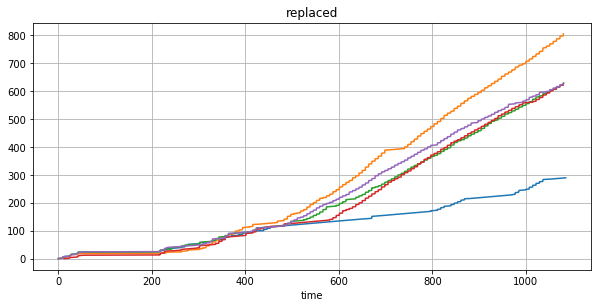

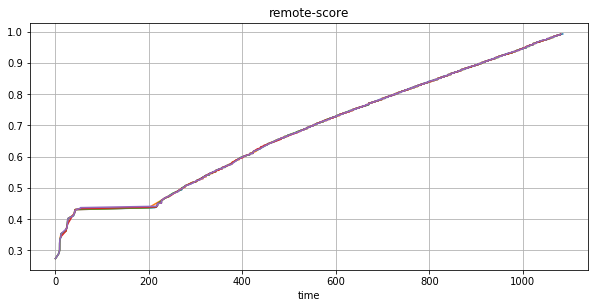

In [178]:
for field in ["replaced", "remote-score"]:
    plt.figure(figsize=(10, 10))
    ax2=plt.subplot(212)
    for i in range(6):
        # ax = plt.subplot(3, 2, i + 1)
        df = model_replace[model_replace["node"] == i]
        if df.shape[0]:
            df.plot(
                x="time", y=field,
                grid=True,
                ax=ax2, title=field,
                legend=None
            );